<a href="https://colab.research.google.com/github/ConnorJamesRice/Movie-Recommendations-/blob/main/matrix_completion_and_recommendation_systems_started_code_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Matrix Completion and Recommendation System

We will use the 100K MovieLens dataset available at https://grouplens.org/datasets/movielens/100k/ to estimate unknown user ratings given their previous ratings.

Create a copy of this notebook and upload to Google Colad. Download the dataset and upload ``u.data`` under the "Files" tab in the sidebar (**NOTE:** you will need to re-upload this file if you disconnect and delete the current runtime).

In [3]:
import csv
import numpy as np
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt
from statistics import fmean
import time

Let's load the 100K MovieLens data.

In [4]:
data = []
with open('u.data') as csvfile:
    spamreader = csv.reader(csvfile, delimiter='\t')
    for row in spamreader:
        data.append([int(row[0])-1, int(row[1])-1, int(row[2])])
data = np.array(data)

num_observations = len(data)  # num_observations = 100,000
num_users = max(data[:,0])+1  # num_users = 943, indexed 0,...,942
num_items = max(data[:,1])+1  # num_items = 1682 indexed 0,...,1681

np.random.seed(1)
num_train = int(0.8*num_observations)
perm = np.random.permutation(data.shape[0])
train = data[perm[0:num_train],:]
test = data[perm[num_train::],:]

print(f"Successfully loaded 100K MovieLens dataset with",
      f"{len(train)} training samples and {len(test)} test samples")

Successfully loaded 100K MovieLens dataset with 80000 training samples and 20000 test samples


Our first estimator pools all users together and, for each movie, outputs as its prediction the average user rating of that movie in ``train``. That is, if $\mu \in \mathbb{R}^m$ is a vector where $\mu_i$ is the average rating of the users that rated the $i$-th movie. Write this estimator $\widehat{R}$ as a rank-one matrix.

Compute the estimate $\widehat{R}$. What is $\mathcal{E}_{\rm test} (\widehat{R})$ for this estimate?

In [5]:
# Compute estimate
uniques = np.unique(train[:, 1])
averages = [np.mean(train[train[:, 1] == u, 2]) for u in uniques]
# Give the average movie rating as a default value, for any movies that do not have any rating data
mu = fmean(averages) * np.ones(num_items)
# Populate the vector mu with the per-movie averages
mu[uniques] = averages
R_hat = np.repeat(mu[:, None], num_users, axis=1)
# Evaluate test error
estimate = R_hat[test[:, 1], test[:, 0]]
error = np.sum((estimate - test[:, 2]) ** 2) / len(estimate)
error


1.0532428361498423

Creating a matrix $\widetilde{R}_{i, j} \in \mathbb{R}^{m \times n}$ and set its entries equal to the known values in the training set, and $0$ otherwise.

Let $\widehat{R}^{(d)}$ be the best rank-$d$ approximation (in terms of squared error) approximation to $\widetilde{R}$. This is equivalent to computing the singular value decomposition (SVD) and using the top $d$ singular values. This learns a lower-dimensional vector representation for users and movies, assuming that each user would give a rating of $0$ to any movie they have not reviewed.

- For each $d = 1, 2, 5, 10, 20, 50$, compute the estimator $\widehat{R}^{(d)}$.
- Plots the average squared error of predictions on the training set and test set on a single plot, as a function of $d$.

In [6]:
# Create the matrix R twiddle (\widetilde{R}).
R_twiddle = np.zeros((num_items, num_users))
R_twiddle[train[:, 1], train[:, 0]] = train[:, 2]
R_twiddle

array([[0., 4., 0., ..., 0., 0., 0.],
       [3., 0., 0., ..., 0., 0., 5.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [7]:
def construct_estimator(d, r_twiddle):
  return svds(r_twiddle, d)

def get_error(d, r_twiddle, dataset):
  estimates = np.zeros(len(dataset))
  u, s, v = construct_estimator(d, R_twiddle)
  for i in range(len(estimates)):
    estimates[i] = np.dot(s * u[dataset[i, 1], :], v[:, dataset[i, 0]])
  return np.sum((estimates - dataset[:, 2]) ** 2) / len(estimates)

print('error:', get_error(50, R_twiddle, test))

error: 8.2610336451543


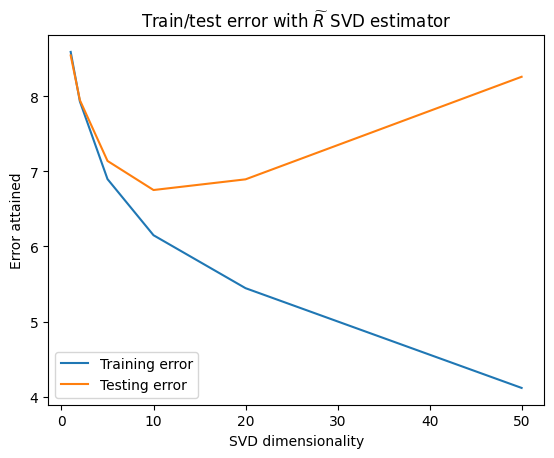

In [8]:
# Evaluating train and test error for: d = 1, 2, 5, 10, 20, 50.
d_vals = [1, 2, 5, 10, 20, 50]
train_errors = [get_error(d, R_twiddle, train) for d in d_vals]
test_errors = [get_error(d, R_twiddle, test) for d in d_vals]

# Plotting both train and test error as a function of d on the same plot.
plt.plot(d_vals, train_errors, label='Training error')
plt.plot(d_vals, test_errors, label='Testing error')
plt.xlabel('SVD dimensionality')
plt.ylabel('Error attained')
plt.title('Train/test error with $\widetilde{R}$ SVD estimator')
plt.legend(loc='best')
plt.show()


Replacing all missing values by a constant may impose strong and potentially incorrect assumptions on the unobserved entries of $R$. A more reasonable choice is to minimize the mean squared error (MSE) only on rated movies. Define a loss function:
$$
\mathcal{L} \left( \{u_i\}_{i=1}^m, \{v_j\}_{j=1}^n \right) :=
\sum_{(i, j, R_{i, j}) \in {\rm train}} (\langle u_i,v_j\rangle - R_{i,j})^2 +
\lambda \sum_{i=1}^m \|u_i\|_2^2 +
\lambda \sum_{j=1}^n \|v_j\|_2^2
$$
where $\lambda > 0$ is the regularization coefficient. We will implement algorithms to learn vector representations by minimizing the above loss.

Implement alternating minimization and plots the MSE of ``train`` and ``test`` for $d \in \{1, 2, 5, 10, 20, 50\}$.

In [9]:
unique_movies = np.unique(train[:, 1])
unique_users = np.unique(train[:, 0])

movies_to_users = {u: train[train[:, 1] == u] for u in unique_movies}
users_to_movies = {u: train[train[:, 0] == u] for u in unique_users}

def closed_form_u(V, U, lam):
  new_U, d = (np.zeros_like(U), U.shape[1])

  for i, u in enumerate(unique_movies):
    V_j = V[movies_to_users[u][:, 0], :]
    new_U[u, :] = np.linalg.solve(
    np.sum(V_j[:, :, None] @ V_j[:, None, :] + lam * np.eye(d), axis=0),
    np.sum(V_j * movies_to_users[u][:, 2][:, None], axis=0)
    )

  return new_U

def closed_form_v(V, U, lam):
  new_V, d = (np.zeros_like(V), V.shape[1])

  for i, u in enumerate(unique_users):
    U_j = U[users_to_movies[u][:, 1], :]
    new_V[u, :] = np.linalg.solve(
    np.sum(U_j[:, :, None] @ U_j[:, None, :] + lam * np.eye(d), axis=0),
    np.sum(U_j * users_to_movies[u][:, 2][:, None], axis=0)
    )

  return new_V

def construct_alternating_estimator(
d, r_twiddle, lam=0.0, delta=1e-5, sigma=0.1, U=None, V=None
):
  U = sigma * np.random.rand(num_items, d)
  V = sigma * np.random.rand(num_users, d)

  for k in range(10000):
    old_U, old_V = (np.copy(U), np.copy(V))
    U = closed_form_u(V, U, lam)
    V = closed_form_v(V, U, lam)
    U_delta, V_delta = (np.max(np.abs(U - old_U)), np.max(np.abs(V - old_V)))
    if k % 5 == 0:
      print(f'\rd={d}, Iteration {k}, U delta: {U_delta}, V delta: {V_delta}',
      ' ', ' ', end='')
      if max(U_delta, V_delta) <= delta:
        break

  return U, V

Finished finding estimations with dimension values [1, 2, 5, 10, 20, 50]  in 254.54563808441162 seconds


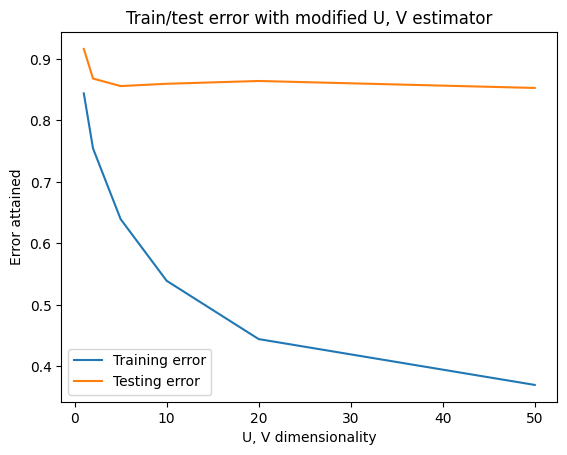

In [10]:
# Evaluating train and test error for: d = 1, 2, 5, 10, 20, 50.
d_vals = [1, 2, 5, 10, 20, 50]

datasets, errors = ({'train': train, 'test': test}, {'train': [], 'test': []})
start_time = time.time()
for d in d_vals:
  U, V = construct_alternating_estimator(d, R_twiddle, lam=0.1, delta=0.01)
  for s in datasets:
    estimates = np.zeros(len(datasets[s]))
    for i in range(len(estimates)):
      estimates[i] = np.dot(U[datasets[s][i, 1], :], V[datasets[s][i, 0], :])
    errors[s].append(np.sum((estimates - datasets[s][:, 2]) ** 2) / len(estimates))

print(f'\rFinished finding estimations with dimension values {d_vals} '
  f' in {time.time() - start_time} seconds')

# Plotting both train and test error as a function of d on the same plot.
plt.plot(d_vals, errors['train'], label='Training error')
plt.plot(d_vals, errors['test'], label='Testing error')
plt.xlabel('U, V dimensionality')
plt.ylabel('Error attained')
plt.title('Train/test error with modified U, V estimator')
plt.legend(loc='best')
plt.show()

While what we have above works well for finding movie rating predictions, there is a lack of a hyperparmater search to optimize and minimize the error of our model. One potential supervised learning algorithm we can use to approach this problem is the k-nearest
neighbor method: $$\hat{R}_{ij} = \frac{1}{K}\sum_{k\in N_K(i,j)} R_{kj}$$ Where $N_K(i,j):=\{K: \#[r(k, j)] > 0, d(R_k, R_j ) \leq DK(i, j)\}$, $D_K(i, j) = max_{s\in\mathbb{R}^+}
\{s : \#[N(i, j)]\leq K\}$, $\#(·)$ is the set cardinality, d(·) is a distance metric, $R_{kj}$ is the entry in the $k^{th}$ row and $j^{th}$ column of our estimator matrix $\hat{R}$, and $K \in \mathbb{N}$ is some amount of desire nearest neighbors.

Choosing $d(R_k, R_j) = \sum_{i\in r(k,j)} |R_{ik}-R_{ij}|$ as our metric, the following modified regularized k-nearest neighbors estimator $\hat{R}_{ij}$ can be derived as:
$$\hat{\mu}_K = \frac{1}{\#[N_k(i,j)]}\sum_{k\in N_k(i,j)} R_{kj}$$

$$ \hat{R}_{ij}=   \left\{
\begin{array}{ll}
      \bar{R}_j & \text{if } \#[r(i,j)] = 0 \\
      \hat{mu}_K+\lambda_v\sigma^2(R_{kj})(\bar{R}_j-\hat{\mu}_K)+\lambda_\ell\frac{H(K-1-\#[N_k(i,j)])}{\#[N_k(i,j)]^p}+b & \text{else}\\
\end{array}
\right.$$
Where $H(\cdot)$ is the Heaviside step fucntion.

##The parameters
We will use this model to attempt to find a relatively accurate estimator $\hat{R}$, including finding an
optimal combination of values for all the parameters described above:

• K, the number of neighbors to average over.

• $\epsilon$, the skew value to apply to the distance metric d.

• $\lambda_v$, the regularization scale factor multiplied to the variance of the nearest neighbor rating
values and shifting the estimate toward the user’s mean rating.

• $\lambda_\ell$, the regularization scale factor divided by the length (cardinality) of the set of neighbors
and shifting the estimate toward the user’s mean rating, but only in the case that there are
less than K neighbors.

• p, an exponent applied to the cardinality of the set of neighbors in the denominator of the
term associated with the regularization factor $\lambda_\ell$.

• b, a bias term added to all ratings to account for any tendency toward over- or underestimation.

To be able preform the hyperparameter search we first have to define the training and validation set.
In order to tune these parameters for this k-NN model, we partition the training data set into a
training subset with 80% of the data and a validation set with 20% of the data. We define an
observation matrix analogous to $\widetilde{R}$ based specifically on this training subset, as well as the per-user
rating average $\bar{R}_j$ and the mapping from users to ratings i ∈ r(j).

In [11]:
# The model works in general for the various random states I've tried it on,
# but we use a random seed here for direct reproducibility
np.random.seed(0)
shuffle = np.random.choice(range(len(train)), size=len(train), replace=False)
train_subset = train[shuffle[:int(.8 * len(shuffle))]]
val_subset = train[shuffle[int(.8 * len(shuffle)):]]

In [12]:
# This method specifically iterates through users, so it feels more natural to
# iterate through a matrix where rows (instead of columns) correspond to users
R_u = np.zeros_like(R_twiddle.T) * 1.
for t in train_subset:
  R_u[t[0]][t[1]] = t[2]

R_u

array([[0., 3., 0., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 0., 0.]])

In [13]:
train_min, train_max = np.min(train_subset[:, 2]), np.max(train_subset[:, 2])
per_user_avgs = {u : np.mean(train_subset[train_subset[:,0] == u][:, 2]) for u in np.unique(train_subset[:,0])}

unique_users = np.unique(train_subset[:, 0])
users_to_movies = {u: train_subset[train_subset[:, 0] == u] for u in unique_users}

k-NN estimator function. We define a function for our modified regularized k-nearest neighbors estimator, consistent with the
formulation described above.

In [15]:
def knn_estimator(R_u, K, epsilon, lam_v, lam_l, len_exponent, bias):
  R_u_new = R_u.copy()
  for i in range(len(R_u)):
    if i % 10 == 0:
      print(f'\rEvaluating user #{i}', end='')
    diff_matrix = R_u[i] - R_u
    prod_matrix = R_u[i] * R_u
    diff_matrix[prod_matrix == 0] = 0
    overlap_counts = np.count_nonzero(prod_matrix, axis=1) * 1.

    # Minor perturbation to handle the divide by zero case
    overlap_counts[overlap_counts == 0] = 1e-10
    distances = np.sum(epsilon + np.abs(diff_matrix), axis=1) / overlap_counts
    sort = np.argsort(distances)

    assigned = {m: [] for m in range(len(R_u.T))}
    for s in sort:
      for j, m in enumerate(users_to_movies[s][:,1]):
        if len(assigned[m]) < K:
          assigned[m].append(users_to_movies[s][j,2])

    for a in assigned:
      if len(assigned[a]) == 0:
        R_u_new[i, a] = per_user_avgs[i]
      elif len(assigned[a]) < K:
        avg_val = fmean(assigned[a])
        R_u_new[i, a] = (avg_val + lam_v * np.var(assigned[a]) * (per_user_avgs[i] - avg_val) + lam_l / (len(assigned[a]) ** len_exponent) * (per_user_avgs[i] - avg_val))
      else:
        avg_val = fmean(assigned[a])
        R_u_new[i, a] = avg_val + lam_v * np.var(assigned[a]) * (per_user_avgs[i] - avg_val)
      R_u_new[i, a] += bias
      R_u_new[i, a] = (R_u_new[i, a] if R_u_new[i, a] < train_max else train_max)
      R_u_new[i, a] = (R_u_new[i, a] if R_u_new[i, a] > train_min else train_min)

  return R_u_new

We will now preform a parameter search.
At this point, we begin the laborious search for optimal parameters to use for our estimator model,
searching for parameters to minimize the validation mean squared error. We use an iterative process (grid search)
to iterate through plausible ranges for all our parameters, to fit the best parameters to our problem.

In [ ]:
param_ranges = {
  'epsilon': [0.001 * i for i in range(11)],
  'lam_v': [0.04 * i for i in range(16)],
  'lam_l': [0.1 * i for i in range(11)],
  'p': [3, 2, 1, 1/2, 1/3, 1/4],
  'bias': [0.1 * i for i in range(-5, 5)],
  'K': [2, 6, 10, 14, 18, 22, 26, 30]
}

param_range_indices = {p: [i for i in range(len(param_ranges[p]))] for p in param_ranges}
next_search_ranges = param_range_indices.copy()

# Initialize everything at 0, except for p = 2, bias = 5, and K = 2
best_indices = {'epsilon': 0, 'lam_v': 0, 'lam_l': 0, 'p': 2, 'bias': 5, 'K': 2}
current_best_mse = np.inf

start_time = time.time()

something_changed = True
while something_changed:
  something_changed = False
  for key in next_search_ranges:
    params = {param: param_ranges[param][best_indices[param]] for param in param_ranges}

    for n in next_search_ranges[key]:
      params[key] = param_ranges[key][n]
      estimator = knn_estimator(R_u, params['K'], params['epsilon'], params['lam_v'], params['lam_l'], params['p'], params['bias'])
      mse = np.mean((estimator[(val_subset[:, 0], val_subset[:, 1])] - val_subset[:, 2]) ** 2)
      print(f'\rMSE={mse}, ' + ', '.join([f'{param}={params[param]}' for param in params]))

      if mse < current_best_mse:
        current_best_mse = mse
        something_changed = True
        best_indices[key] = n
        print(f'New optimal parameter found: {key}={params[key]}')

    best_idx = best_indices[key]
    next_search_ranges[key] = param_range_indices[key][best_idx - 2 : best_idx + 3]

optimal_parameters = {k : param_ranges[k][best_indices[k]] for k in best_indices}
print('Optimal parameters found:', optimal_parameters)
print(f'Parameter search finished in {time.time() - start_time} seconds')

MSE=1.0024407715330763, epsilon=0.0, lam_v=0.0, lam_l=0.0, p=1, bias=0.0, K=10
New optimal parameter found: epsilon=0.0
MSE=0.9687920215330762, epsilon=0.001, lam_v=0.0, lam_l=0.0, p=1, bias=0.0, K=10
New optimal parameter found: epsilon=0.001
MSE=0.9661563965330763, epsilon=0.002, lam_v=0.0, lam_l=0.0, p=1, bias=0.0, K=10
New optimal parameter found: epsilon=0.002
MSE=0.9652982715330762, epsilon=0.003, lam_v=0.0, lam_l=0.0, p=1, bias=0.0, K=10
New optimal parameter found: epsilon=0.003
MSE=0.9673982715330762, epsilon=0.004, lam_v=0.0, lam_l=0.0, p=1, bias=0.0, K=10
MSE=0.9712045215330762, epsilon=0.005, lam_v=0.0, lam_l=0.0, p=1, bias=0.0, K=10
MSE=0.9744195215330762, epsilon=0.006, lam_v=0.0, lam_l=0.0, p=1, bias=0.0, K=10
MSE=0.9741776465330763, epsilon=0.007, lam_v=0.0, lam_l=0.0, p=1, bias=0.0, K=10
MSE=0.9752570215330763, epsilon=0.008, lam_v=0.0, lam_l=0.0, p=1, bias=0.0, K=10
MSE=0.9766863965330762, epsilon=0.009000000000000001, lam_v=0.0, lam_l=0.0, p=1, bias=0.0, K=10
MSE=0.9

We will now test our best configuration.
We seem to have found a relatively optimal set of parameters for our model. Having found these parameters to lower
the validation MSE as much as possible, we test our optimal configuration against the test set. For this part, we use
the entire training set instead of the subset that was used for parameter tuning, which requires us to redefine a few
of our variables accordingly.

In [ ]:
R_u = np.zeros_like(R_twiddle.T) * 1.
for t in train:
  R_u[t[0]][t[1]] = t[2]

R_u

In [ ]:
train_min, train_max = np.min(train[:, 2]), np.max(train[:, 2])
per_user_avgs = {u : np.mean(train[train[:,0] == u][:, 2]) for u in np.unique(train[:,0])}

unique_users = np.unique(train[:, 0])
users_to_movies = {u: train[train[:, 0] == u] for u in unique_users}

In [ ]:
lam_v = optimal_parameters['lam_v']
lam_l = optimal_parameters['lam_l']
epsilon = optimal_parameters['epsilon']
K = optimal_parameters['K']
bias = optimal_parameters['bias']
p = optimal_parameters['p']

R_u_new = knn_estimator(R_u, K, epsilon, lam_v, lam_l, p, bias)

MSE = np.mean((R_u_new[(test[:, 0], test[:, 1])] - test[:, 2]) ** 2)
print(f'\rMSE={MSE}, K={K}, epsilon={epsilon}, lam_v={lam_v}, lam_l={lam_l}, 'f'bias={bias}, p={p}')

We observe that with the correct choice of parameters, the model successfully attains a training error of
below 0.9, often lower than the minimal validation layer it attained. This makes sense since we are this
time training on the entire training data set, which is larger. We can drive this mean squared error even lower
with a more refined choice of parameters for our model, but what we have here is sufficient to demonstrate the process.